# BBC News Classification
A Jupyter notebook with exploratory data analysis (EDA) procedure, model building and training, and comparison with supervised learning for classifying news article. Matrix factorization will be used to predict the category.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
from collections import  Counter
import itertools

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# EDA and data cleaning
import re
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import missingno as msno

#modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\licat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\licat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
### 1.1. Data import and basic inspection
In this step, I will load the dataset provided by [Kaggle Competition: BBC News Classification](https://www.kaggle.com/competitions/learn-ai-bbc/data)

**File descriptions**
- BBC News Train.csv - the training set of 1490 records
- BBC News Test.csv - the test set of 736 records

In [2]:
train = pd.read_csv('./data/BBC News Train.csv')
train.info()
train.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


<bound method NDFrame.head of       ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          business

In [3]:
test = pd.read_csv('./data/BBC News Test.csv')
test.info()
test.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


<bound method NDFrame.head of      ArticleId                                               Text
0         1018  qpr keeper day heads for preston queens park r...
1         1319  software watching while you work software that...
2         1138  d arcy injury adds to ireland woe gordon d arc...
3          459  india s reliance family feud heats up the ongo...
4         1020  boro suffer morrison injury blow middlesbrough...
..         ...                                                ...
730       1923  eu to probe alitalia  state aid  the european ...
731        373  u2 to play at grammy awards show irish rock ba...
732       1704  sport betting rules in spotlight a group of mp...
733        206  alfa romeos  to get gm engines  fiat is to sto...
734        471  citizenship event for 18s touted citizenship c...

[735 rows x 2 columns]>

In [4]:
test.shape

(735, 2)

### 1.2. Inspect null values
In this step, I will identify null values on the dataset.

In [5]:
# Inspect nulls
train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

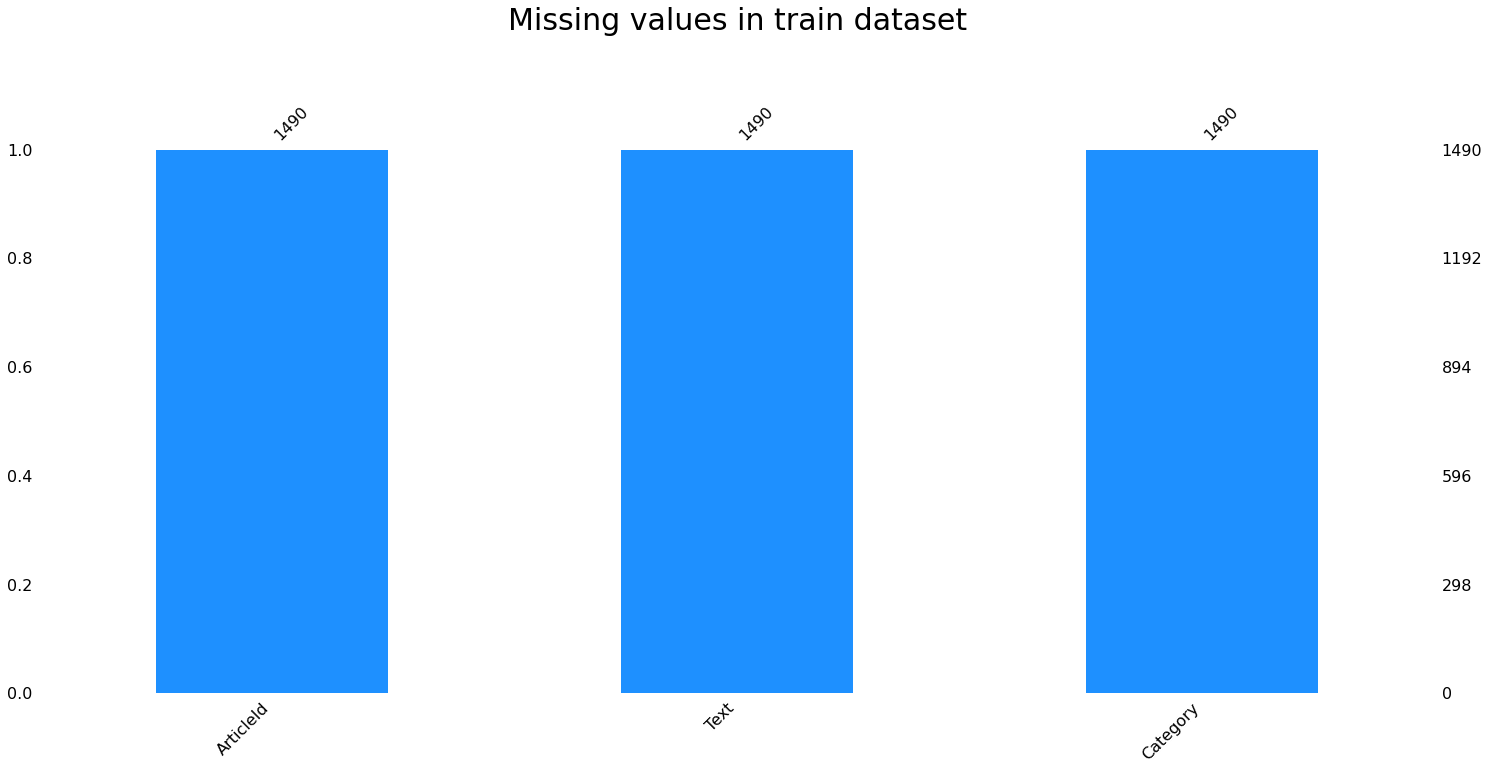

In [6]:
msno.bar(train,color = 'dodgerblue')
plt.title('Missing values in train dataset\n\n',fontsize=30)
plt.show()

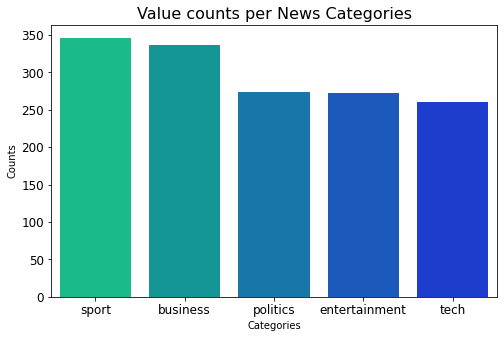

In [7]:
# Value counts per category
trainCat = train.Category.value_counts()

fig, axis = plt.subplots(1, 1, figsize=(8,5))
graph = sns.barplot(x=trainCat.index, y=trainCat, palette='winter_r')
t = graph.set_title("Value counts per News Categories",fontsize=16)
t = plt.xlabel('Categories')
t = plt.ylabel('Counts')
plt.tick_params(labelsize = 12)

### 1.3. Assign the categories with numbers
In this step, I will assign the categories with numbers to a new column called 'CategoryID' to the original dataframe

In [8]:
#Create a new column for CategoryID
train['CategoryID'] = train['Category'].factorize()[0]
train

,ArticleId,Text,Category,CategoryID
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,1


In [9]:
#Create panda dataframe
categoryid_df = train[['CategoryID', 'Category']].drop_duplicates() \
                .sort_values('CategoryID')
#Creae a dictionary based on Category ID dataframe
category_to_id = dict(categoryid_df.values)
id_to_category = dict(categoryid_df[['CategoryID', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

### 1.4. Clean data
In this step, I will clean the data by doing the following:
- Removing punctuations
- Removing numbers
- Removing extra spaces
- Lemmatization (The process of converting a word to its base form)

In [10]:
#Cleaning the data 
def data_cleaning(dataframe):
    #remove all punctuations
    dataframe["cleanText"] = dataframe['Text'].str.replace('[^\w\s]','',regex=True)
    #remove numbers
    dataframe["cleanText"] = dataframe["cleanText"].str.replace('\d+','',regex=True)
    #remove stopwords
    stop = stopwords.words('english')
    dataframe['cleanText'] = dataframe['cleanText'] \
    .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #remove extra spaces
    dataframe['cleanText'] = dataframe['cleanText'] \
    .apply(lambda x: re.sub(' +', ' ', x))
    #lemmatize words
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    def lemmatize_text(text):
        return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    dataframe['lemmText'] = dataframe['cleanText'].apply(lemmatize_text)    
    
#Cleaning train and test data
data_cleaning(train)
train['numwords'] = train['lemmText'].apply(lambda lst: len(lst))

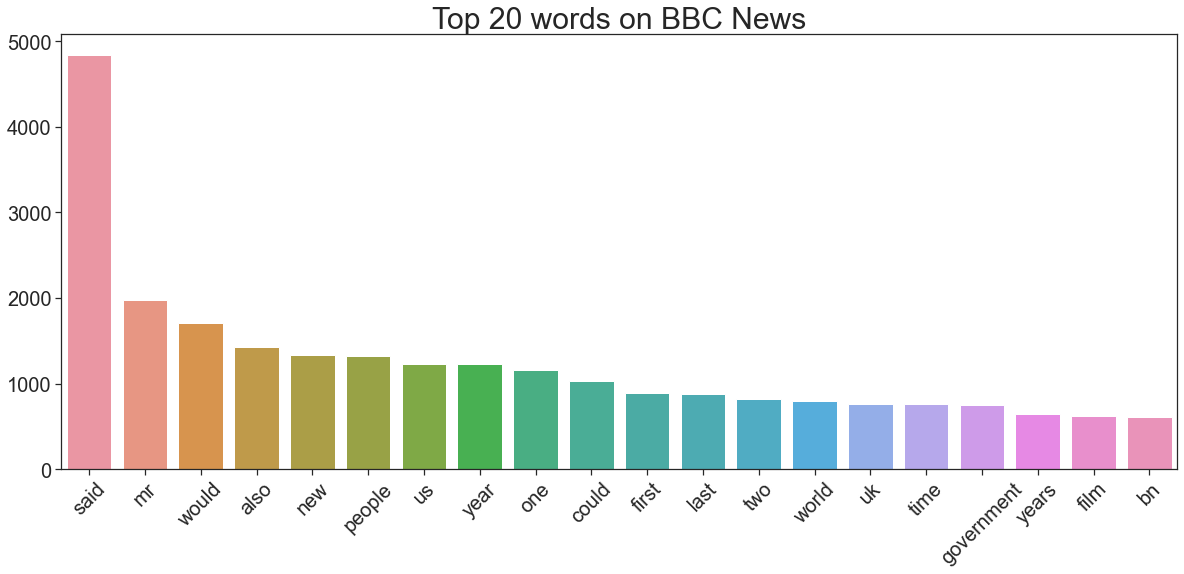

In [11]:
#Plot the top 20 words
def top_frequent_words(data):
    stop=set(stopwords.words('english'))
    data_split= data.str.split()
    data_list=data_split.values.tolist()
    corpus=[word for i in data_list for word in i]
    counter=Counter(corpus)
    mostCommon=counter.most_common()
    x, y=[], []
    for word,count in mostCommon[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count) 
    sns.set(rc={"figure.figsize":(20, 8)}) #width=3, #height=4
    sns.set_style("ticks")
    plot = sns.barplot(x=x,y=y)
    plt.title('Top 20 words on BBC News',fontsize=30)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize = 20)
top_frequent_words(train['cleanText'])

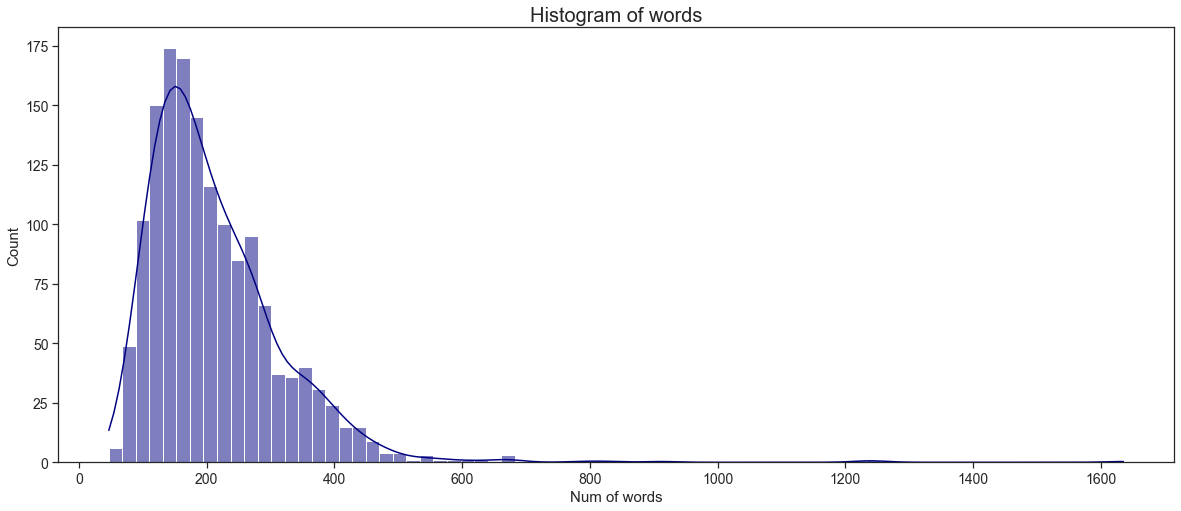

In [12]:
# Plot the histogram of word to examine the data distribution
sns.set(rc={"figure.figsize":(20, 8)})
sns.set_style("ticks")
plot = sns.histplot(
    data = train, 
    x = 'numwords',
    color='navy',
    kde = True
    )
plot.set_xlabel('Num of words', fontsize = 15)
plot.set_ylabel('Count', fontsize = 15)
plot.set_title("Histogram of words", fontsize = 20)
plt.tick_params(labelsize = 14)

### 1.5. Plan for  feature extraction
To analyze the smilarities between pieces of text, I will use the TF-IDF technique which weighs a term's frequency and its inverse. I decided to use this technique because it is easy to use and simple to calculate.

In [13]:
#TF-IDF technique for train data
train_tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
train_features = train_tfidf.fit_transform(train.cleanText).toarray() 
train_features.shape

(1490, 10000)

In [14]:
#TF-IDF technique for test data
test_tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
test_features = test_tfidf.fit_transform(test.Text).toarray() 
test_features.shape

(735, 10000)

## 2. Building and training models

### 2.1. Train with unsupervised learning
In this step, I will apply matrix factorization and train with K-Means unsupervised model using a selected random cluster number which is 5.

In [15]:
#Fit transform the tfidf vectorizer
tfidvec = TfidfVectorizer(sublinear_tf=True, 
                          min_df=5, norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')
features = tfidvec.fit_transform(train.cleanText).toarray() 
labels = train.CategoryID  

#Applying K-Means algorithm
kmeans = KMeans(n_clusters = 5, 
                init = 'k-means++', 
                random_state = 0)
kmeans.fit_transform(tfidvec.fit_transform(train['Text']))
k_labels = kmeans.labels_

k_labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(train['CategoryID'] == k_labels)
catID = train['CategoryID']

print("Result: %d out of %d samples were correctly labeled." 
      % (correct_labels, catID.size))
print('Accuracy score: {0:0.2f}'
      .format(correct_labels/float(catID.size)))

Result: 276 out of 1490 samples were correctly labeled.
Accuracy score: 0.19


### 2.2. Tuning hyperparameters
In this step, I search for the optimal number of clusters from 1 to 10

In [16]:
acc = []
for idx in range(1,11):
    kmeans = KMeans(n_clusters = idx, 
                    init = 'k-means++', 
                    random_state = 0)
    kmeans.fit_transform(tfidvec.fit_transform(train['Text']))
    k_labels = kmeans.labels_

    # check how many of the samples were correctly labeled
    correct_labels = sum(train['CategoryID'] == k_labels)
    catID = train['CategoryID']
    acc.append(correct_labels/float(catID.size))

acc = np.array(acc)
maxacc = np.max(acc)
idxacc = acc.argmax()
print('Best Accuracy score: {0:0.2f} for cluster {1}'. format(maxacc, idxacc))

Best Accuracy score: 0.42 for cluster 3


## 3. Compare with supervised learning

### 3.1 Supervised Learning
In this step, I will use the following Logistic Regression supervised learning:

In [17]:
#Applying Logistic Regression
model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, 
                labels, 
                train.index, 
                test_size=0.33, 
                random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 21.453125, 'Predicted')

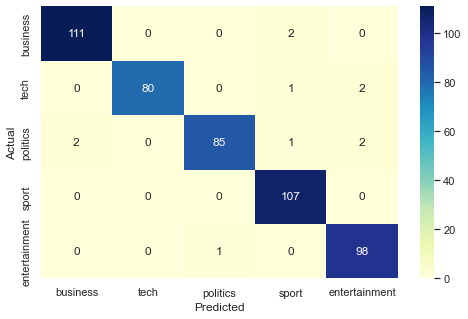

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc={"figure.figsize":(8, 5)})
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categoryid_df.Category.values, 
            yticklabels=categoryid_df.Category.values, 
            cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

### 3.3. Compare with other models
In this step, I will compare other supervised learning by measuring their accuracy

In [19]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [20]:
CV = 5  # Cross Validate with 5 different folds of 20% data

#Create a data frame that will store the results for all 
#5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [21]:
#For each Algorithm 
for model in models:
    model_name = model.__class__.__name__
    # create 5 models with different 20% test sets, and store their accuracies
    accuracies = cross_val_score(model, 
                                 features, 
                                 labels, 
                                 scoring='accuracy', 
                                 cv=CV)
    # Append all 5 accuracies into the entries list 
    #(after all 3 models are run, there will be 3x5 = 15 entries)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.838926
1,RandomForestClassifier,1,0.832215
2,RandomForestClassifier,2,0.812081
3,RandomForestClassifier,3,0.865772
4,RandomForestClassifier,4,0.875839
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.956376
7,MultinomialNB,2,0.979866
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

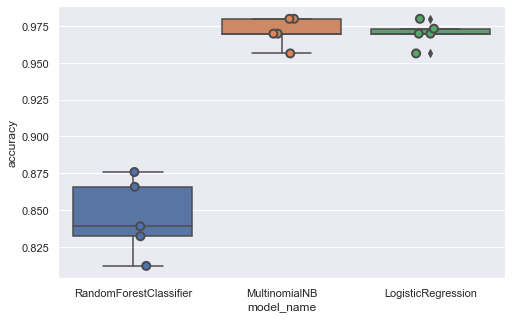

In [22]:
sns.set(rc={"figure.figsize":(8, 5)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

## 4. Prediction
In this step, I will predict the category for the test data

In [28]:
#Fit transform the tfidf vectorizer
tfidvec = TfidfVectorizer(sublinear_tf=True, 
                          min_df=5, 
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')
features = tfidvec.fit_transform(train.cleanText).toarray() 

#Applying Logistic Regression
model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features, 
                labels, 
                train.index, 
                test_size=0.33, 
                random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

#Predict test data
test_features = tfidvec.transform(test.Text.tolist())
Y_pred = model.predict(test_features)

#Find the label by category ID
Y_pred_name =[]
for cat_id in Y_pred :
    Y_pred_name.append(id_to_category[cat_id])
    
#Create a dataframe with the predicted category for test data
predict_df = pd.DataFrame({'articleID':test.ArticleId  , 
                           'Category':np.array(Y_pred_name)})
predict_df.head(10)

,articleID,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


## 5. Conclusions

The first step done on this project was exploring the data and inspecting null values. Then, the training data was cleaned by removing punctuations, numbers, extra spaces and lemmatization. The second step done was creating a matrix factorization model, and applying unsupervised and supervised learning. For unsupervised learning, I applied the K-means algorithm. Initially, I selected a random cluster number. Then, I applied a process to find the best optimal cluster number. For supervised learning, I applied three algorithms: Ransom Forest Classifier, Multinomial Naive Bayes and Logistic Regression. Comparing the accuracy, the supervised learning algorithms did better than the unsupervised algorithm. Finally, I used one of the supervised algorithm to predict the category for the test data.

A future enhance on the project will be modify other parameters for the K-means algorithm and not only the cluster number parameter. Also, use other unsupervised learning algorithms such as NMF. 